# SUMMARY: manipulation of input windows for  CIFAR-100 trained model

### load CNN model

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5103)


In [2]:
from keras.models import load_model

In [3]:
CNN_model = load_model('F:/Kaggle/The Nature Conservancy/cnn_models/cnn_cifar100_with_fish_table_outdoor_people_2.h5')

In [1]:
import numpy as np

from PIL import Image
import os, sys
import glob

In [2]:
# The load_path function loads the .jpg image and converts it to a numpy array. 
# It also extracts the image label from path and places it into file_array
import os
from PIL import Image
import time

def load_data(paths):
    
    X = []
    file_array = []
    label_array = []
  
    # Images are resized because they range from 720-924 and 1192-1280 Making it difficult to use in models
    # and neural networks
    # Most 'common' original image size
    # The 'im.resize' switches these dimensions. That is why they are backwards here.
    size = 1280, 720
    
    print('..loading images')
    start = time.time()
    
    # if loading 'training set' also extract label from file
        
    for path in glob.glob(paths):

        try:
            # load image and convert to np array
            im = Image.open(path)
            im = im.resize((size[0], size[1]))
            im = np.asarray(im)
            X.append(im)

            # extract file name EX: img_00003.jpg
            base = os.path.basename(path)
            file_array.append(base)

            if 'train' in paths:
                # extract fish label (ALB, BET, DOL, LAG, NoF, OTEHR, SHARK, YFT)
                directory = os.path.split(path)[0]
                label_array.append(os.path.split(directory)[1])

        except IOError:
            print( "cannot load or resize image for %s" % path)


    print('time elapsed: ' + str(time.time() - start))

    if 'train' in paths:
        return X, file_array, label_array

    else:
        return X, file_array


In [3]:
X, file_array, label_array = load_data('F:/Kaggle/The Nature Conservancy/train/train/*/*')

..loading images


KeyboardInterrupt: 

In [7]:
X_train = np.asarray(X)

In [8]:
# reshape X for cnn (samples, channels, rows, columns)
# where X is originally (samples, rows, columns, channels)
def reshape_for_cnn(X):
    
    X_cnn = np.zeros([X.shape[0], X.shape[3], X.shape[1], X.shape[2]])
    for samples in xrange(X.shape[0]):
        for channels in xrange(X.shape[3]):
            X_cnn[samples,channels,:,:] = X[samples,:,:,channels]
            
    return X_cnn

In [9]:
def create_batch(X, Y, index, batch_size):
    X_batch = X[index:index+batch_size,:,:,:]
    #X_batch = np.float16(X_batch)/255
    
    Y_batch = Y[index:index+batch_size,:]
    return X_batch, Y_batch

In [10]:
def shrink(data, rows, cols):
    return data.reshape(rows, data.shape[0]/rows, cols, data.shape[1]/cols).sum(axis=1).sum(axis=2)

In [394]:
# extracts list of 320x320 sub-images from image X
def create_windows_from_image(X):
    window_height = 320
    window_width = 320
    #window_height = 500
    #window_width = 500
    window_slide = 50
    window_horizontal_idx = 0
    window_vertical_idx = 0
    window_array = []
    horizontal_num_windows = 0
    vertical_num_windows = 0

    #slide horizontal then vertical
    while (window_vertical_idx+window_height) <= X.shape[1]:


        while (window_horizontal_idx+window_width) <= X.shape[2]:
            X_temp = X[0,window_vertical_idx:window_vertical_idx+window_height,
                             window_horizontal_idx:window_horizontal_idx+window_width,:]
            window_array.append(X_temp)
            window_horizontal_idx += window_slide
            horizontal_num_windows += 1
        window_horizontal_idx = 0
        horizontal_num_windows = 0
        window_vertical_idx += window_slide
        vertical_num_windows += 1
    
    return window_array

In [13]:
# convert label_array containing m number of labels, in this case, 8 different types of fish, to a one-hot encoded array
def convert_to_one_hot(label_array):
    n = len(label_array) #number of samples
    m = 8 #number of types of fish
    
    classification_array = np.zeros(n)
 
    # assign numerical label to each type of fish
    for sample in xrange(n):
        
        if label_array[sample] == 'ALB':
            classification_array[sample] = 0
            
        elif label_array[sample] == 'BET':
            classification_array[sample] = 1
            
        elif label_array[sample] == 'DOL':
            classification_array[sample] = 2
        
        elif label_array[sample] == 'LAG':
            classification_array[sample] = 3
            
        elif label_array[sample] == 'NoF':
            classification_array[sample] = 4
            
        elif label_array[sample] == 'OTHER':
            classification_array[sample] = 5
            
        elif label_array[sample] == 'SHARK':
            classification_array[sample] = 6
            
        elif label_array[sample] == 'YFT':
            classification_array[sample] = 7
            
    # covert array to to one-hot encoded array        
    one_hot_array = np.eye(m)[classification_array.astype(int)]
            
    return classification_array, one_hot_array

In [14]:
from random import shuffle

def shuffle_X_and_Y(X, Y):
    # Given list X and list Y
    
    X_shuf = []
    Y_shuf = []
    
    index_shuf = np.arange(len(X))
    
    #shuffle it twice!
    shuffle(index_shuf)
    shuffle(index_shuf)
    
    for i in xrange(len(X)):
        X_shuf.append(X[index_shuf[i]])
        Y_shuf.append(Y[index_shuf[i]])
        
    return(X_shuf, Y_shuf)

# Scikit for image size reduction

## how does model do with larger window increments?

In [631]:
from skimage.measure import compare_psnr

In [659]:
a = compare_psnr(X_train[2575,:,:,:], X_train[2567,:,:,:])

In [660]:
a

11.437476988358226

In [746]:
SAMPLE = 3700

In [747]:
X_window_list = create_windows_from_image(X_train[SAMPLE:SAMPLE+1,:,:,:])

In [748]:
X_reduced_window_list = []
for sample in xrange(len(X_window_list)):
    temp_window = block_reduce(X_window_list[sample], block_size=(10, 10, 1), func=np.mean).astype(int)
    X_reduced_window_list.append(temp_window)

In [749]:
X_reduced_window_list[0].shape

(32L, 32L, 3L)

In [750]:
X_reduced_array = np.asarray(X_reduced_window_list)

In [751]:
X_cnn = reshape_for_cnn(X_reduced_array)

In [752]:
fish_locations = CNN_model.predict(X_cnn)

In [753]:
good_predictions = np.where(fish_locations[:,0] >= .1)

In [754]:
good_predictions

(array([155, 171], dtype=int64),)

In [755]:
for channel in xrange(3):
    print(np.sum(X_train[SAMPLE:SAMPLE+1,:,:,channel]))

97131127
99521638
102977498


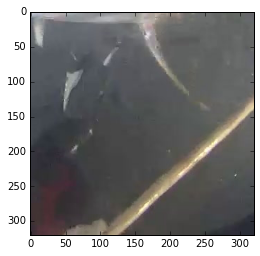

In [757]:
imshow(X_window_list[good_predictions[0][0]])

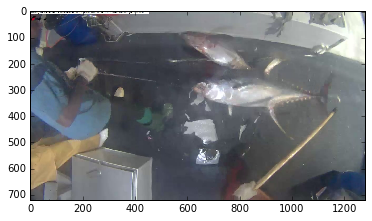

In [758]:
imshow(X_train[SAMPLE,:,:,:])

In [562]:
from skimage.exposure import adjust_gamma

In [579]:
brighten_image = adjust_gamma(X_train[SAMPLE,:,:,:], gamma=.8)

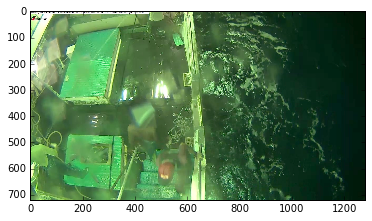

In [580]:
imshow(brighten_image)

In [572]:
np.mean(brighten_image)

207.51238353587962

In [ ]:
skimage.exposure.adjust_gamma(image, gamma=1, gain=1)[source]

In [561]:
np.mean(X_window_list[good_predictions[0][0]])

131.96454427083333

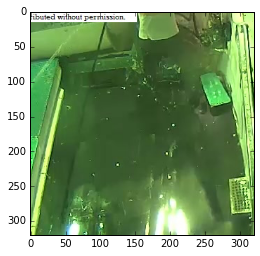

In [556]:
imshow(X_window_list[good_predictions[0][]])

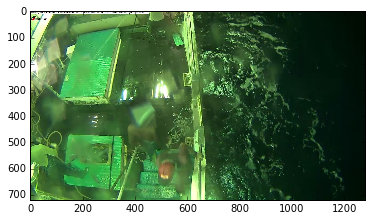

In [557]:
imshow(X_train[SAMPLE,:,:,:])

In [104]:
X_window_list[206][0,:10,:10]

array([[39, 54, 87],
       [39, 54, 87],
       [39, 53, 88],
       [39, 53, 90],
       [39, 53, 90],
       [39, 53, 88],
       [39, 53, 88],
       [40, 54, 91],
       [38, 53, 82],
       [38, 53, 82]], dtype=uint8)

In [105]:
X_window_list[207][0,:10,:10]

array([[35, 53, 77],
       [35, 51, 74],
       [33, 49, 74],
       [32, 48, 73],
       [32, 48, 71],
       [33, 48, 71],
       [36, 46, 71],
       [36, 46, 71],
       [38, 46, 69],
       [38, 46, 69]], dtype=uint8)

In [15]:
from skimage.measure import block_reduce

In [56]:
from skimage.color import rgb2gray

In [57]:
image.shape

(32L, 32L, 3L)

In [75]:
sample = 2000
image_gray = rgb2gray(X_train[sample,:,:,:])

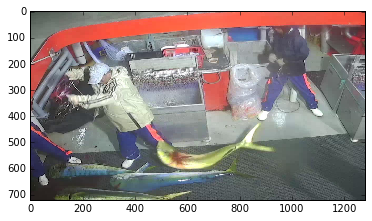

In [76]:
imshow(X_train[sample,:,:,:])

In [23]:
X_sample = X[0][:,:,:]

In [24]:
X_sample.shape

(720L, 1280L, 3L)

In [30]:
image_reduce = block_reduce(X_sample, block_size=(3, 3, 1), func=np.mean).astype(int)

In [37]:
X_window_list = create_windows_from_image(X_train[0:1,:,:,:])

In [38]:
len(X_window_list)

1029

In [39]:
X_window_list[0].shape

(320L, 320L, 3L)

In [40]:
image = block_reduce(X_window_list[0], block_size=(10, 10, 1), func=np.mean).astype(int)

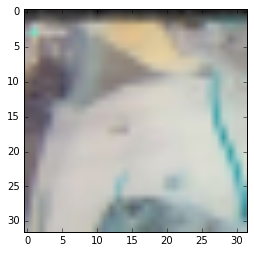

In [55]:
imshow(image)

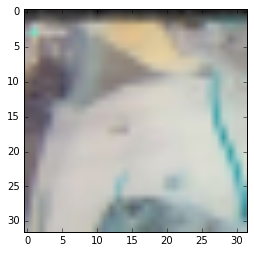

In [44]:
imshow(image)

array([[[215, 216, 214],
        [219, 218, 217],
        [197, 197, 195],
        ..., 
        [217, 218, 218],
        [210, 211, 209],
        [222, 223, 222]],

       [[185, 188, 186],
        [176, 179, 174],
        [157, 161, 165],
        ..., 
        [190, 161, 163],
        [184, 159, 159],
        [181, 159, 160]],

       [[118, 131, 123],
        [ 77,  67,  63],
        [ 70,  80,  94],
        ..., 
        [126,  97, 102],
        [129, 109, 113],
        [124, 113, 114]],

       ..., 
       [[127, 131, 112],
        [ 74,  74,  87],
        [104,  98, 102],
        ..., 
        [ 61,  52,  57],
        [ 99,  61,  74],
        [187, 119, 110]],

       [[108, 110, 100],
        [ 73,  74,  89],
        [105, 101, 102],
        ..., 
        [ 79,  63,  61],
        [100,  66,  68],
        [133,  87,  80]],

       [[ 92,  93,  89],
        [ 73,  75,  90],
        [108, 104, 105],
        ..., 
        [ 98,  77,  73],
        [ 91,  72,  68],
        [ 84,  65,

In [41]:
image_reduce.shape

(240L, 427L, 3L)

In [32]:
image_reduce

array([[[253, 254, 253],
        [252, 253, 253],
        [254, 253, 249],
        ..., 
        [ 96,  91,  87],
        [ 98,  93,  89],
        [ 66,  63,  60]],

       [[252, 254, 252],
        [186, 180, 175],
        [174, 181, 185],
        ..., 
        [103,  98,  94],
        [102,  97,  93],
        [ 67,  64,  61]],

       [[254, 252, 247],
        [145, 146, 140],
        [139, 143, 143],
        ..., 
        [103,  98,  94],
        [102,  97,  93],
        [ 68,  64,  62]],

       ..., 
       [[ 45,  54,  69],
        [ 45,  54,  69],
        [ 49,  58,  73],
        ..., 
        [ 48,  57,  78],
        [ 47,  58,  80],
        [ 32,  39,  54]],

       [[ 45,  55,  69],
        [ 45,  54,  68],
        [ 48,  58,  72],
        ..., 
        [ 53,  63,  76],
        [ 52,  60,  78],
        [ 35,  40,  54]],

       [[ 45,  55,  67],
        [ 45,  55,  67],
        [ 48,  58,  70],
        ..., 
        [ 61,  71,  85],
        [ 61,  67,  89],
        [ 41,  45,

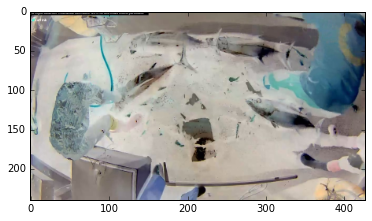

In [33]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

# imshow(np.asarray(X_train[0,100:400,300:600,:])) really good example (confidence of fish: 99%)
imshow(image_reduce, cmap='Greys_r')

In [16]:
len(X)

3777

In [ ]:
block_reduce(image, block_size=(3, 3, 1), func=np.mean)

In [14]:
classification_array, Y = convert_to_one_hot(label_array)

In [15]:
Y.shape

(3777L, 8L)

In [16]:
#number of samples in each class
num_fishes = []
for fish in xrange(Y.shape[1]):
    num_fishes.append(np.sum(Y[:,fish]))
    print np.sum(Y[:,fish])

1719.0
200.0
117.0
67.0
465.0
299.0
176.0
734.0


In [18]:
np.sum(num_fishes[:])

3777.0

In [19]:
np.sum(num_fishes[:8])

3777.0

In [17]:
from collections import defaultdict

keys=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']
window_dic = defaultdict(list)

In [38]:
# reduce train size for computation reduction

In [39]:
X_train = X_train[1500:,:,:,:]

In [40]:
Y = Y[1500:,:]

In [41]:
#number of samples in each class
num_fishes = []
for fish in xrange(Y.shape[1]):
    num_fishes.append(np.sum(Y[:,fish]))
    print np.sum(Y[:,fish])

219.0
200.0
117.0
67.0
465.0
299.0
176.0
734.0


In [42]:
np.sum(num_fishes)

2277.0

In [ ]:
import time

In [46]:
keys=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']
window_dic = defaultdict(list)
tot_time = time.time()

for sample in xrange(X_train.shape[0]):
    
    start = time.time()
    
    # create window array from original image
    temp_windows = create_windows_from_image(X_train[sample:sample+1,:,:,:])
    
    # reduce 320x320 windows to 32x32 for CNN
    reduced_temp_windows = reduce_windows(temp_windows)

    # reshape windows for CNN (samples, channels, rows, columns)
    temp_X_cnn = reshape_for_cnn(reduced_temp_windows)
    
    #run windows through previously trained CIFAR-10 cnn model
    reduced_predictions = CNN_model.predict(temp_X_cnn)
    
    #take best predictions
    good_predictions = np.where(reduced_predictions[:,0] >= 0.99999)[0]
    
    # windows corresponding to high confidence for respective fish class example
    if sample <= np.sum(num_fishes[:1]):
        for i in xrange(len(good_predictions)):
            window_dic['ALB'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:2]):
        for i in xrange(len(good_predictions)):
            window_dic['BET'].append(temp_windows[good_predictions[i]])
          
    elif sample <= np.sum(num_fishes[:3]):
        for i in xrange(len(good_predictions)):
            window_dic['DOL'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:4]):
        for i in xrange(len(good_predictions)):
            window_dic['LAG'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:5]):
        for i in xrange(len(good_predictions)):
            window_dic['NoF'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:6]):
        for i in xrange(len(good_predictions)):
            window_dic['OTHER'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:7]):
        for i in xrange(len(good_predictions)):
            window_dic['SHARK'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:8]):
        for i in xrange(len(good_predictions)):
            window_dic['YFT'].append(temp_windows[good_predictions[i]])

    
    print('time elapsed: ' + str(time.time()  - start) + ', sample: ' + str(sample))
    
print('')
print('done')
print('total time elapsed: ' + str(time.time() - tot_time))

time elapsed: 13.4189999104, sample: 0
time elapsed: 13.4680001736, sample: 1
time elapsed: 13.7239999771, sample: 2
time elapsed: 12.9219999313, sample: 3
time elapsed: 13.3320000172, sample: 4
time elapsed: 13.3380000591, sample: 5
time elapsed: 13.3190000057, sample: 6
time elapsed: 13.6349999905, sample: 7
time elapsed: 13.5390000343, sample: 8
time elapsed: 13.876999855, sample: 9
time elapsed: 13.4949998856, sample: 10
time elapsed: 13.5740001202, sample: 11
time elapsed: 13.2189998627, sample: 12
time elapsed: 13.1679999828, sample: 13
time elapsed: 13.373000145, sample: 14
time elapsed: 13.3069999218, sample: 15
time elapsed: 13.4110000134, sample: 16
time elapsed: 13.3240001202, sample: 17
time elapsed: 13.4089999199, sample: 18
time elapsed: 12.513999939, sample: 19
time elapsed: 13.1050000191, sample: 20
time elapsed: 13.5859999657, sample: 21
time elapsed: 13.3330001831, sample: 22
time elapsed: 13.3779997826, sample: 23
time elapsed: 13.4940001965, sample: 24
time elapsed:

In [32]:
len(window_dic['ALB'])

1717

In [ ]:
keys=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']

In [54]:
len(window_dic['YFT'])

5573

In [58]:
window_dic['YFT'][0].shape

(320L, 320L, 3L)

In [6]:
import numpy as np

# Save
#dictionary = {'hello':'world'}
np.save('F:\Kaggle\The Nature Conservancy\window_dic library/window_dic_model_2_2_099999.npy', window_dic) 



NameError: name 'window_dic' is not defined

In [7]:
import numpy as np

In [8]:
# Load
window_dic = np.load('F:\Kaggle\The Nature Conservancy\window_dic library/window_dic_model_2_2_099999.npy').item()
#print(read_dictionary['hello']) # displays "world"

## how'd the CNN do in finding correct fish examples? 

## from visual inspection: not great. Under 50% 

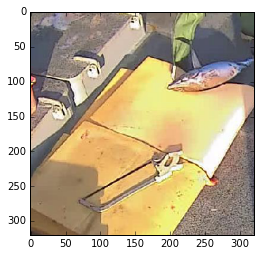

In [116]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

# imshow(np.asarray(X_train[0,100:400,300:600,:])) really good example (confidence of fish: 99%)
imshow(np.asarray(window_dic['ALB'][0]))

# creat single list from dictionary

In [9]:
keys=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']

In [10]:
X_list = []
num_fish_array = []
for key in keys:
    num_fish_windows = len(window_dic[key])
    num_fish_array.append(num_fish_windows)
    
    for i in xrange(num_fish_windows):
        X_list.append(window_dic[key][i])

In [11]:
Y_list = []
for i in xrange(len(num_fish_array)):
    for j in xrange(num_fish_array[i]):
        Y_list.append(i)

In [12]:
len(X_list)

31403

In [14]:
X_list_reduced = 0

In [15]:
X_list_reduced = reduce_windows(X_list, 80, 80)

In [13]:
len(Y_list)

31403

In [17]:
X_list_reduced[0].shape

(80L, 80L, 3L)

# shuffle X_list and Y_list

In [18]:
X_shuff, Y_shuff = shuffle_X_and_Y(X_list_reduced, Y_list)

In [19]:
X_train = np.asarray(X_shuff)

In [73]:
Y_train = np_utils.to_categorical(np.asarray(Y_shuff), 8)

In [21]:
X_train.shape

(31403L, 80L, 80L, 3L)

# divide X_train by reduction factor (4*4) and normalize by 255

In [30]:
X_train = X_train/(4*4*255.0)

# train CNN using window array containing fish classes

In [51]:
X_train.shape

(31403L, 80L, 80L, 3L)

In [52]:
Y_train.shape

(31403L, 8L)

In [59]:
X_cnn = reshape_for_cnn(X_train)

In [66]:
X_cnn.shape

(31403L, 3L, 80L, 80L)

In [74]:
X_train = X_cnn

In [75]:
X_train2 = X_train[:25000,:,:,:]
Y_train2 = Y_train[:25000,:]

X_test = X_train[25000:,:,:,:]
Y_test = Y_train[25000:,:]

In [76]:
Y_test.shape

(6403L, 8L)

In [77]:
X_train = X_train2
Y_train = Y_train2

In [78]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
GPU run command:
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python cifar10_cnn.py
It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).
Note: the data was pickled with Python 2, and some encoding issues might prevent you
from loading it in Python 3. You might have to load it in Python 2,
save it in a different format, load it in Python 3 and repickle it.
'''

from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

batch_size = 32
nb_classes = 8
nb_epoch = 25
data_augmentation = True

# input image dimensions
img_rows, img_cols = 80, 80
# the CIFAR10 images are RGB
img_channels = 3

# the data, shuffled and split between train and test sets
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(64, 3, 3, border_mode='same',
                        input_shape=(3,80,80)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(256, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(512, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(512, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        zoom_range=[1-0.3, 1+0.3]) # Float or [lower, upper]. Range for random zoom. 
                                   # If a float,  [lower, upper] = [1-zoom_range, 1+zoom_range
        
        
    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)
    

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_test, Y_test)),
                              #verbose=False)
    

X_train shape: (25000L, 3L, 80L, 80L)
25000 train samples
6403 test samples
Using real-time data augmentation.
Epoch 1/25
25000/25000 [==============================] - 234s - loss: 1.6723 - acc: 0.2957 - val_loss: 1.4172 - val_acc: 0.4445
Epoch 2/25
25000/25000 [==============================] - 234s - loss: 1.2442 - acc: 0.5405 - val_loss: 0.9174 - val_acc: 0.6933
Epoch 3/25
25000/25000 [==============================] - 234s - loss: 0.8129 - acc: 0.7341 - val_loss: 0.5221 - val_acc: 0.8146
Epoch 4/25
25000/25000 [==============================] - 233s - loss: 0.5592 - acc: 0.8204 - val_loss: 0.6898 - val_acc: 0.8351
Epoch 5/25
25000/25000 [==============================] - 233s - loss: 0.4059 - acc: 0.8779 - val_loss: 0.2360 - val_acc: 0.9299
Epoch 6/25
25000/25000 [==============================] - 234s - loss: 0.3285 - acc: 0.9046 - val_loss: 0.2780 - val_acc: 0.9085
Epoch 7/25
25000/25000 [==============================] - 234s - loss: 0.2560 - acc: 0.9250 - val_loss: 0.1264 - va

In [79]:
model.save('F:/Kaggle/The Nature Conservancy/cnn_models/cnn_trained_on_image_windows_25epoch.h5')

In [12]:
from keras.models import load_model

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5103)


In [13]:
model = load_model('F:/Kaggle/The Nature Conservancy/cnn_models/cnn_trained_on_image_windows_25epoch.h5')

In [14]:
X_test, file_array_test = load_data('F:/Kaggle/The Nature Conservancy/test_stg1/test_stg1/*')

..loading images
time elapsed: 34.9389998913


In [25]:
X_test_array = np.asarray(X_test)

In [21]:
X_test_reduced_window_list[0].shape

(15633L, 80L, 80L, 3L)

In [19]:
X_test_reduced_window_list = []
for sample in xrange(len(X_test)):

    # create windows
    X_temp_array = X_test_array[sample:sample+1,:,:,:]
    temp_window_list = create_windows_from_image(X_temp_array)
    
    
    # convert windows from 320x320 to 80x80 (being lazy here)
    test_window_list_reduced = reduce_windows(temp_window_list, 80, 80)
    X_test_reduced_window_list.append(test_window_list_reduced)
    
    print('sample: %d' %sample)

sample: 0
sample: 1
sample: 2
sample: 3
sample: 4
sample: 5
sample: 6


KeyboardInterrupt: 

In [17]:
len(test_window_list_reduced)

180

In [26]:
test_predictions = np.zeros([len(X_test), 8])

for sample in xrange(len(X_test)):

    start = time.time()
    
    # create windows
    X_temp_array = X_test_array[sample:sample+1,:,:,:]
    temp_window_list = create_windows_from_image(X_temp_array)
    
    
    # convert windows from 320x320 to 80x80 (being lazy here)
    test_window_list_reduced = reduce_windows(temp_window_list, 80, 80)
    
    
    # convert list to array and change shape for second cnn
    temp_window_array = np.asarray(test_window_list_reduced)
    temp_cnn = reshape_for_cnn(temp_window_array)
    
    #normalize (should still mean-center)
    temp_cnn /= 4*4*255.0
    
    
    test_predict = model.predict(temp_cnn)

    test_predictions[sample,:] = np.mean(test_predict, axis=0)
    
    #np.save('F:/Kaggle/The Nature Conservancy/test_predictions' , test_predictions)
    
    print('sample %d' %sample + ', time elapsed: %f' %(time.time() - start))

sample 0, time elapsed: 3.770000
sample 1, time elapsed: 3.344000
sample 2, time elapsed: 3.412000
sample 3, time elapsed: 3.517000
sample 4, time elapsed: 3.557000
sample 5, time elapsed: 3.461000
sample 6, time elapsed: 3.468000
sample 7, time elapsed: 3.504000
sample 8, time elapsed: 3.368000
sample 9, time elapsed: 3.483000
sample 10, time elapsed: 3.568000
sample 11, time elapsed: 3.405000
sample 12, time elapsed: 3.324000
sample 13, time elapsed: 3.314000
sample 14, time elapsed: 3.345000
sample 15, time elapsed: 3.362000
sample 16, time elapsed: 3.286000
sample 17, time elapsed: 3.341000
sample 18, time elapsed: 3.392000
sample 19, time elapsed: 3.299000
sample 20, time elapsed: 3.647000
sample 21, time elapsed: 3.530000
sample 22, time elapsed: 3.539000
sample 23, time elapsed: 3.638000
sample 24, time elapsed: 3.635000
sample 25, time elapsed: 3.601000
sample 26, time elapsed: 3.515000
sample 27, time elapsed: 3.506000
sample 28, time elapsed: 3.767000
sample 29, time elapsed:

In [27]:
test_predictions.shape

(1000L, 8L)

In [30]:
test_prediction = test_predictions

In [129]:
np.sum(test_predict[:,7])

2064.8506

In [31]:
# save
#test_prediction = numpy.reshape(test_prediction, [len(test_prediction), 1])
file_label = np.reshape(file_array_test, [len(file_array_test), 1])
labels_and_predictions = np.append(file_label, test_prediction, axis=1)
np.savetxt("F:/Kaggle/The Nature Conservancy/submissions/my_submission7.csv", labels_and_predictions,
           delimiter=',',fmt='%s', header= 'image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT', comments='' )

In [ ]:
####### for a single image -> do predict on CNN1 and CNN2 and store prediction?
####### or just not use the first CNN on classifying test windows
# run windows through first CNN to extract windows containing fish
keys=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']
window_dic = defaultdict(list)
tot_time = time.time()

for sample in xrange(X_train.shape[0]):
    
    start = time.time()
    
    # create window array from original image
    temp_windows = create_windows_from_image(X_train[sample:sample+1,:,:,:])
    
    # reduce 320x320 windows to 32x32 for CNN
    reduced_temp_windows = reduce_windows(temp_windows)

    # reshape windows for CNN (samples, channels, rows, columns)
    temp_X_cnn = reshape_for_cnn(reduced_temp_windows)
    
    #run windows through previously trained CIFAR-10 cnn model
    reduced_predictions = CNN_model.predict(temp_X_cnn)
    
    #take best predictions
    good_predictions = np.where(reduced_predictions[:,0] >= 0.99999)[0]
    
    # windows corresponding to high confidence for respective fish class example
    if sample <= np.sum(num_fishes[:1]):
        for i in xrange(len(good_predictions)):
            window_dic['ALB'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:2]):
        for i in xrange(len(good_predictions)):
            window_dic['BET'].append(temp_windows[good_predictions[i]])
          
    elif sample <= np.sum(num_fishes[:3]):
        for i in xrange(len(good_predictions)):
            window_dic['DOL'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:4]):
        for i in xrange(len(good_predictions)):
            window_dic['LAG'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:5]):
        for i in xrange(len(good_predictions)):
            window_dic['NoF'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:6]):
        for i in xrange(len(good_predictions)):
            window_dic['OTHER'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:7]):
        for i in xrange(len(good_predictions)):
            window_dic['SHARK'].append(temp_windows[good_predictions[i]])
        
    elif sample <= np.sum(num_fishes[:8]):
        for i in xrange(len(good_predictions)):
            window_dic['YFT'].append(temp_windows[good_predictions[i]])

    
    print('time elapsed: ' + str(time.time()  - start) + ', sample: ' + str(sample))
    
print('')
print('done')
print('total time elapsed: ' + str(time.time() - tot_time))


In [42]:
#model.summary()